# Validazione e ottimizzazione iperparametri

In questo capitolo cercheremo di migliorare i risultati ottenuti con i passi precedenti, ottimizzando gli algoritmi e valutando bene i risultati.

## Caricamento del dataset e utilizzo delle pipeline
In questo capitolo utilizzeremo il dataset *Breast Cancer Wisconsin* le prime due colonne sono un identificativo del caso e la diagnosi corrispondente le caratterstiche dalla 3 alla 32 sono valori oggettivi ottenuti dalle immagini digitalizzare del nucleo della cellula.

In [1]:
import pandas as pd
df = pd.read_csv('./data/data.csv')

df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [2]:
X = df.loc[:,'radius_mean':'fractal_dimension_worst']
y = df.loc[:,'diagnosis']

In [3]:
label_map = {'M': 1, 'B': 0}
y = y.map(label_map)

Ora che abbiamo creato il dataset nel formato desiderato andiamo a dividere i dati in due parti, l'80% verranno utilizzati per l'addestramento (train) mentre il 20% per testare la correttezza del nostro sistema (test).

In [4]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.20)

### Combinare estimatori e trasformatori in una pipeline

Creiamo ora un sistema che esegua in un solo passo la trasformazione PCA vista nella lezione precedente e la regressione logistica.
Per svolgere questo lavoro usiamo l'oggetto `Pipeline`

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

pipeline = make_pipeline(StandardScaler(),PCA(n_components=2),LogisticRegression(solver='lbfgs'))
pipeline.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('logisticregression', LogisticRegression())])

In [6]:
score = pipeline.score(X_test,y_test)
print("Test accuracy: {0:.3f}".format(score))

Test accuracy: 0.930


La funzione `make_pipeline` accetta in ingresso un numero arbitrario di transformer (che supportano sia il metodo `fit` che il metodo `transform`) seguito da un oggetto estimatore che implementa i metodi `fit` e `predict`.

Possiamo pensare che l'oggetto `Pipeline` sia una box in cui quando chiamiamo il metodo `fit` i dati passano attraverso tutti i trasformatori (viene chiamato il metodo `fit`) fino ad arrivare al trasformatore finale.

Quando invece viene chiamato il metodo `predict` i dati passano attravesrso i trasformatori utilizzando il metodo `tranform` fino ad arrivare alla fine dove incontrano l'estimatore in cui viene richiamato il metodo `predict`.

## Utilizzo della convalida incrociata k-fold per valutare le prestazioni del modello

Per impostare bene il nostro modello dobbiamo trovare un buon compromesso tra underfitting e overfitting nei prossimi passi affronteremo le varie strategie per per stimare l'errore di generalizzazione.

### Il modello holdout
L'approccio classico per la stima delle prestazioni è il modello holdout, con esso si divide il dataset in due parti train e test. Il primo viene ovviamente utilizzato per il train ed il secondo per il test finale tuttavia siamo interessati anche ad ottimizziare i parametri che lo stesso mette a disposizione *(iperparametri)*. Tuttavia se utilizzassimo i dati di test per l'ottimizzazione essi finirebbero a far parte dei nostri dati di train ed il modello andrebbe certamente in contro ad un problema di overfitting.
Per ovviare a questo problema si divide il dataset di train in due pessi la parte di train e la parte di convalida che verrà utilizzata per calcorare la migliore combinazione di iperparametri.
Una volta eseguito questi passaggi potremmo finalmente utilizzare il dataset di test per controllare il comportamento del modello.
Lo svantaggio di questo sistema sta nel fatto che è fortemente legato al modo in cui i dati vengono divisi.

Nel prossimo paragrafo andremo ad analizzare la convalida incrociata che essenzialmente ripete il modello holdout sul dataset n volte, con una stima più precisa.

### Convalida incrociata K-fold
Nella convalida incrociata K-fold, suddividiamo in modo casuale il dataset di addestramento in k parti senza reinserimento, k-1 parti verranno utilizzate per l'addestramento del modello e l'ultima verrà utilizzata per verificare le caratteristiche del modello. Questa procedura viene ripetuta k volte con k stime di prestazioni.

Per calcolare i parametri migliori da utilizzare sul modello di utilizza il metodo k-fold, una volta eseguito questo passo si riesegue l'addestramento sull'intero dataset di train e si ottiene la stima finale utilizzando il dataset di test.
Il valore standard di k è pari a 10, di solito questo valore è sufficiente per la maggior parte dei casi.
Se stiamo lavorando con dataset piccoli potremo scegliere un valore di k più grande per avere un dataset di addestramento il piu grande possibile. Tuttavia avremo anche dei risultati intermedi con varianzia più elevata.

Per dataset molto grandi invece conviene usare valori più piccoli ad esempio k = 5, per ridurre anche il costo computazionale.

Un leggero miglioramento del sistema k-fold è la convalida incrociata k-fold stratificata, con questo tipo di convalida le proporzioni tra le classi vengono preservate in ciascuna parte, per garantire che ciascuna parte abbia una rappresentazione delle classi uguale.
Qui sotto mostriamo un esempio di come funziona tale iteratore `StratifiedKFold`

In [7]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10)

scores = []
for train_index, test_index in skf.split(X_train,y_train):
    pipeline.fit(X_train.iloc[train_index],y_train.iloc[train_index])
    score = pipeline.score(X_train.iloc[test_index],y_train.iloc[test_index])
    
    print("Class dist {0} accuracy {1:.2f}".format(np.bincount(y_train.iloc[train_index]),score))
    
    scores.append(score)
    
print("CV accuracy {0:.2f} +/- {1:.2f}".format(np.mean(scores),np.std(scores)))

Class dist [256 153] accuracy 0.96
Class dist [256 153] accuracy 0.96
Class dist [256 153] accuracy 0.96
Class dist [256 153] accuracy 0.93
Class dist [256 153] accuracy 0.91
Class dist [257 153] accuracy 0.93
Class dist [257 153] accuracy 0.96
Class dist [257 153] accuracy 0.93
Class dist [257 153] accuracy 1.00
Class dist [257 153] accuracy 0.91
CV accuracy 0.95 +/- 0.02


Sebbene il precedente codice fosse utile per comprendere il funzionamento del metodo sklean implementa già tutti i passaggi attraverso la funzione `cross_val_score`

In [8]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(pipeline,X_train,y_train,cv=10,n_jobs=-1)

print("CV scores {0}".format(scores))
print("CV accuracy {0:.2f} +/- {1:.2f}".format(np.mean(scores),np.std(scores)))

CV scores [0.95652174 0.95652174 0.95652174 0.93478261 0.91304348 0.93333333
 0.95555556 0.93333333 1.         0.91111111]
CV accuracy 0.95 +/- 0.02


una cosa interessante di questo ultimo metodo è che possiamo distribuire la valutazione delle varie parti su più cpu, se impostiamo il parametro `n_jobs=-1` potremmo utilizzare tutte le cpu disponibili.

## Debugging degli algoritmi con le curve di apprendimento e convalida

Ora esamineremo due semplici quanto potenti stumenti per analizzare le perfomance dell'algoritmo 

### Diagnosi dei problemi di bias e varianza con le curve di apprendimento
Se il modello è troppo complesso per un determinato dataset di addestramento il modello tende a non convergere bene sui dati di test e dunque non generalizzare bene su dati mai visti.
Tuttavia basterebbe ottenere più dati per mitigare il problema, questo però può risultare difficile se non impossibile.
Tracciando il comportamento del modello in funzione dell'aumentare dei dataset possiamo individuare se il modello soffre di elevata varianza o bias.


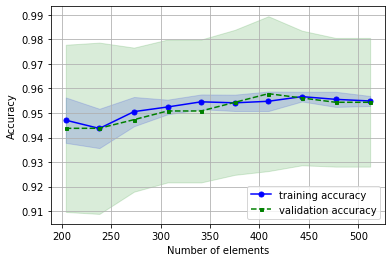

In [9]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(pipeline, X, y, cv=10, n_jobs=-1,train_sizes=np.linspace(0.4,1,10))

train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)

test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)

plt.plot(train_sizes,train_mean,color='blue',marker='o',markersize=5,label='training accuracy')
plt.fill_between(train_sizes,train_mean + train_std,train_mean - train_std,alpha=0.15,color='blue')

plt.plot(train_sizes,test_mean,color='green',marker='s',linestyle="--",markersize=3,label='validation accuracy')
plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std,alpha=0.15,color='green')

plt.grid()

plt.xlabel("Number of elements")
plt.ylabel("Accuracy")
plt.legend(loc = 'lower right')

### Soluzione di problemi di overfitting e underfitting con le curve di convalida

Le curve di convalida sono un ottimo strumento per migliorare le prestazioni di un modello risolvendo i problemi di overfitting. Qui invece di tracciare le curve in funzione della dimensione del campione qui si interviene sui parametri del modello.

Vediamo qui sotto un esempio di curva al variare di C

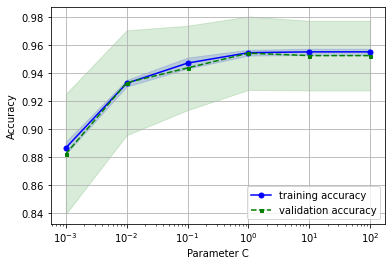

In [10]:
from sklearn.model_selection import validation_curve
param_range = [0.001,0.01,0.1,1.0,10.0,100.0]

train_scores,test_scores =  validation_curve(pipeline, X, y,param_name='logisticregression__C',param_range=param_range,cv=10)

train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)

test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)


plt.plot(param_range,train_mean,color='blue',marker='o',markersize=5,label='training accuracy')
plt.fill_between(param_range,train_mean + train_std,train_mean - train_std,alpha=0.15,color='blue')

plt.plot(param_range,test_mean,color='green',marker='s',linestyle="--",markersize=3,label='validation accuracy')
plt.fill_between(param_range,test_mean + test_std,test_mean - test_std,alpha=0.15,color='green')

plt.grid()
plt.xscale('log')
plt.xlabel("Parameter C")
plt.ylabel("Accuracy")
plt.legend(loc = 'lower right')


notiamo che con c > 1 l'accuratezza non aumenta e si ha inoltre un leggero overfit

## Ottimizzazione dei modelli di machine learning tramite ricerca a griglia
Come abbiamo sempre visto fino ad ora negli algoritmi di machine learning abbiamo due tipi di parametri che vengono appresi, quelli in fase di addestramento e gli iperparametri per esempio la regolarizzazione che devono essere ottimizzati separamatente.

Nel codice precedente abbiamo visto come le curve di convalida ci possano aiutare nel cercare il parametro migliore, ma ora vedremo una tecnica che ci aiuterà nel cercare in automatico i parametri da ottimizzare nel miglior modo possibile.

### Ottimizzazione dei parametri tramite ricerca a griglia
Questo tipo di ricerca è piuttosto semplice si tratta di una ricerca tramite forza bruta, il computer valuta tutte le combinazioni per cercare la combinazione vediamo un esempio pratico

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),SVC())

param_range = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
param_grid = [
    {
    'svc__C':param_range,
    'svc__kernel':['linear']
    },
     {
    'svc__C':param_range,
    'svc__gamma':param_range,
    'svc__kernel':['rbf']
    }
]


gs = GridSearchCV(estimator = pipe_svc,param_grid = param_grid, scoring = 'accuracy', cv = 10, n_jobs = -1)
gs = gs.fit(X_train,y_train)

print("Best score {0:.2f}".format(gs.best_score_))

print(gs.best_params_)

Best score 0.98
{'svc__C': 0.01, 'svc__kernel': 'linear'}


Una volta ottimizzato il modello andiamo a controllare come si comporta nel dataset di test

In [12]:
clf = gs.best_estimator_
clf.fit(X_train,y_train)

score = clf.score(X_test,y_test)
print("Test accuracy {0:.2f}".format(score))

Test accuracy 0.94


sebbene la ricerca a griglia sia uno strumento molto potente, su dataset molto grandi e con molti parametri potremmo avere dei problemi prestazionali.

Un buon approccio potrebbe essere quello di utilizzare la ricerca casuale con la classe `RandomizedSearchCV`

In [13]:
from sklearn.model_selection import RandomizedSearchCV

param_range = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
param_grid = [
    {
    'svc__C':param_range,
    'svc__kernel':['linear']
    },
     {
    'svc__C':param_range,
    'svc__gamma':param_range,
    'svc__kernel':['rbf']
    }
]


rs = RandomizedSearchCV(estimator = pipe_svc,param_distributions = param_grid, scoring = 'accuracy', cv = 10, n_jobs = -1)
rs = rs.fit(X_train,y_train)

print("Best score {0:.2f}".format(rs.best_score_))

print(rs.best_params_)



Best score 0.96
{'svc__kernel': 'linear', 'svc__C': 1000.0}


In [14]:
clf = rs.best_estimator_
clf.fit(X_train,y_train)

score = clf.score(X_test,y_test)
print("Test accuracy {0:.2f}".format(score))

Test accuracy 0.96


## Selezione dell'algoritmo con convalida incrociata nidificata

L'utilizzo della convalida incrociata *k-fold* in combinazione con la ricerca a griglia/randomica è un ottimo strumento per l'ottimizzazione degli iperparametri. Ma se volgiamo selezionare fra vari algoritmi una buona soluzione potrebbe essere quella di utilizzare la convalida incrociata nidificata. 

Si parte da un ciclo esterno dove si usa la cross validation per validare i dati e fornire ad un ciclo più interno gli stessi per ottimizzare i parametri del modello.

La figura qui sotto introduce il concetto di una convalida incrociata 5x2

![convalida incrociata nidificata](./images/crossValidation.png)

Per eseguire questo tipo di convalida con sklearn basta utilizzare le seguenti linee di codice


In [15]:
rs = RandomizedSearchCV(estimator = pipe_svc,param_distributions = param_grid, scoring = 'accuracy', cv = 2, n_jobs = -1)
scores = cross_val_score(rs,X_train,y_train,cv=5,n_jobs=-1)

print("CV accuracy {0:.2f} +/- {1:.2f}".format(np.mean(scores),np.std(scores)))


CV accuracy 0.98 +/- 0.02


## Metrice di valutazione delle prestazioni

Fino ad ora abbiamo sempre utilizzato come metro per la prestazione di un algoritmo l'accuratezza, come vedremo nei prossimi capitoli esistono anche altre metriche prestazionali tra cui: precisione, recall e F1-score

### Lettura di una matrice di confusione

Prima di entrare nel dettaglio di una classe di metriche dobbiamo trattare la cosidetta matrice di confusione.
Questa è una matrice quadrata che contiene il conteggio dei veri positivi, dei veri negativi, dei falsi positivi e dei falsi negativi.

Sebbene questa metrica possa essere calcolata con facilità abbiamo una funzione di sklearn che ci viene in aiuto.


In [17]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train,y_train)
y_pred = pipe_svc.predict(X_test)

matrix = confusion_matrix(y_test,y_pred)
matrix

array([[71,  1],
       [ 2, 40]], dtype=int64)

Text(0.5, 15.0, 'Predicted label')

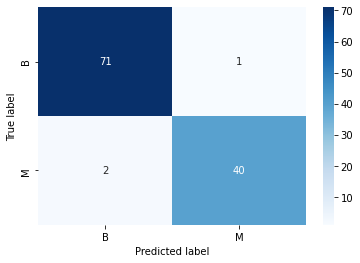

In [21]:
import seaborn as sns

categories = ['B', 'M']
sns.heatmap(matrix, annot=True,cmap='Blues',xticklabels=categories,yticklabels=categories)
plt.ylabel('True label')
plt.xlabel('Predicted label')